## ДЗ 8


   1. Обучите нейронную сеть любой архитектуры, которой не было на курсе, либо обучите нейронную сеть разобранной архитектуры, но на том датасете, которого не было на уроках. Сделайте анализ, того, что вам помогло в улучшении работы нейронной сети.

    вариант для 1) Обучите VAE на fashion_mnist

### Setup


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


### Строим слой семплирования sampling layer


In [ ]:
# стороим кастомный слой 
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a unit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs  # с двумя параметрами на входе
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1] # определяем размер нашего пространства
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim)) # строим шум
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # восстанавливаем пакет единиц информации, опираясь на параметры нашего распределения



### Строим энкодер encoder


In [ ]:
latent_dim = 2 # берем пространство равное 2 для быстроты

encoder_inputs = keras.Input(shape=(28, 28, 1))
# строим сверточную модель
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
# строим выходы
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
# получилась модель: на входе картинка, на выходе 3 тензора
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_10 (Conv2D)             (None, 14, 14, 32)   320         ['input_11[0][0]']               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 7, 7, 64)     18496       ['conv2d_10[0][0]']              
                                                                                                  
 flatten_5 (Flatten)            (None, 3136)         0           ['conv2d_11[0][0]']              
                                                                                            

### Строим свой decoder


In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
# размерность 7 * 7 * 64 позволяет потом построить выход 28
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# превращаем в тензор более сложной формы 4-мерный
x = layers.Reshape((7, 7, 64))(x)
# как тольо сказали strides=2, то увеличили ращмерность в 2 раза
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x) # 14x14
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x) # 28x28
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x) # одноканальная картинка 28x28
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_11 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_15 (Conv2D  (None, 14, 14, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 28, 28, 32)       18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_17 (Conv2D  (None, 28, 28, 1)        289 

### Создаем класс модель по `Model` с особым шагом *обучения* `train_step`


In [ ]:
# создаем модель как наследник класса Model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data): # меняем на свое обучение функцию train_step
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape: # создаем объект для дифферецнирования
            z_mean, z_log_var, z = encoder(data)  # картинки пропускаем через энкодер
            reconstruction = decoder(z) # пропускаем через декодер
            # строим первый loss
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            # строим второй loss
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5 # коэффициент обеспечивает равный вклад двух лоссов
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights) # говорим, что у модели будут тренироваться веса
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }



### Учим VAE


In [ ]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data() # подгружаем FASHION-MNIST
mnist_units = np.concatenate([x_train, x_test], axis=0)
mnist_units = np.expand_dims(mnist_units, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam()) # задаем оптимайзер
vae.fit(mnist_units, epochs=30, batch_size=128) # проводим обучение


Epoch 1/30
547/547 [==============================] - 5s 9ms/step - loss: 315.5147 - reconstruction_loss: 310.0394 - kl_loss: 5.4753
Epoch 2/30
547/547 [==============================] - 5s 8ms/step - loss: 276.2913 - reconstruction_loss: 271.7532 - kl_loss: 4.5382
Epoch 3/30
547/547 [==============================] - 5s 8ms/step - loss: 271.4377 - reconstruction_loss: 267.2739 - kl_loss: 4.1638
Epoch 4/30
547/547 [==============================] - 5s 8ms/step - loss: 268.7615 - reconstruction_loss: 264.7908 - kl_loss: 3.9707
Epoch 5/30
547/547 [==============================] - 5s 8ms/step - loss: 266.6267 - reconstruction_loss: 262.7413 - kl_loss: 3.8853
Epoch 6/30
547/547 [==============================] - 5s 8ms/step - loss: 265.2380 - reconstruction_loss: 261.3938 - kl_loss: 3.8443
Epoch 7/30
547/547 [==============================] - 5s 8ms/step - loss: 264.0486 - reconstruction_loss: 260.2275 - kl_loss: 3.8210
Epoch 8/30
547/547 [==============================] - 5s 8ms/step - l

### Результат предсказания для датасета одежды


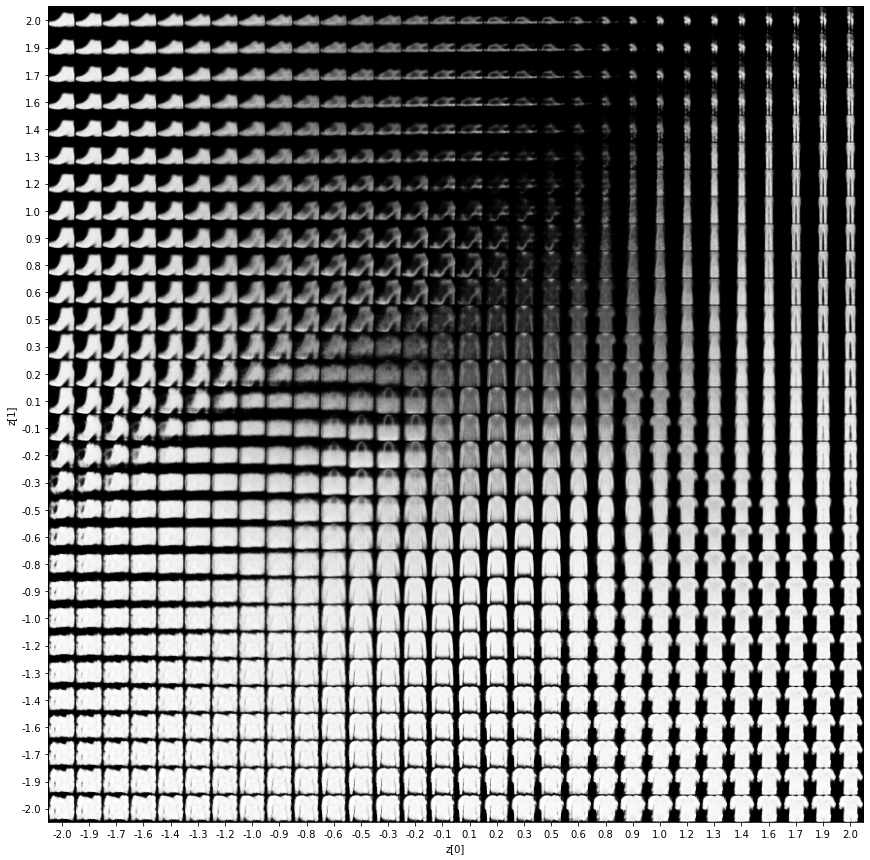

In [ ]:
import matplotlib.pyplot as plt

# на этапе предсказания энкодер не нужен
# По одной точке из скрытого пространства восстанавливаем объект, подавая через декодер
def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of units
    n = 30
    unit_size = 28
    scale = 2.0 # диапазон пространства от минус 2 до 2
    figsize = 15
    figure = np.zeros((unit_size * n, unit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of unit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            unit = x_decoded[0].reshape(unit_size, unit_size)
            figure[
                i * unit_size : (i + 1) * unit_size,
                j * unit_size : (j + 1) * unit_size,
            ] = unit

    plt.figure(figsize=(figsize, figsize))
    start_range = unit_size // 2
    end_range = n * unit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, unit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)


### Посмотрим на кластеры в скрытом пространстве для одежды


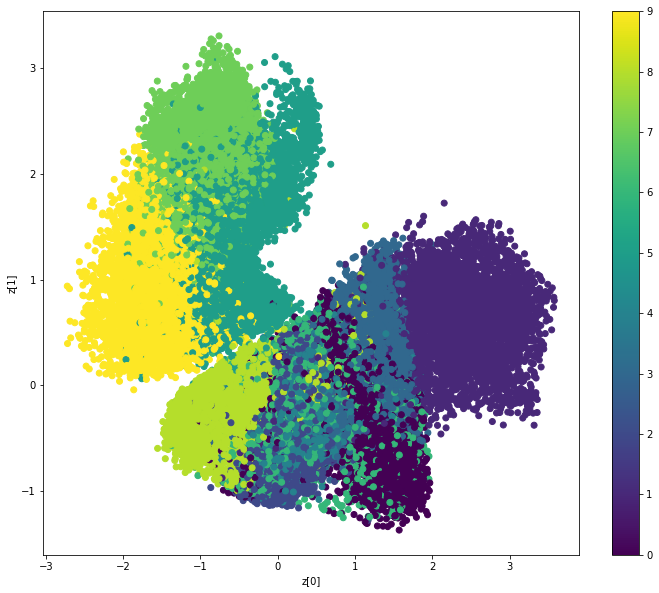

In [ ]:
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the unit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)


Построим немного примеров генерации одежды:

для этого не нужен энкодер
работа этой модели требует:
- выбрать случайные значения для точки скрытого пространства (2 координаты (среднее и логарифм от дисперсиии) - для построения в n (в нашем случае 28х28) координаты нового образца )
- подать их в декодер
- визуализировать результат

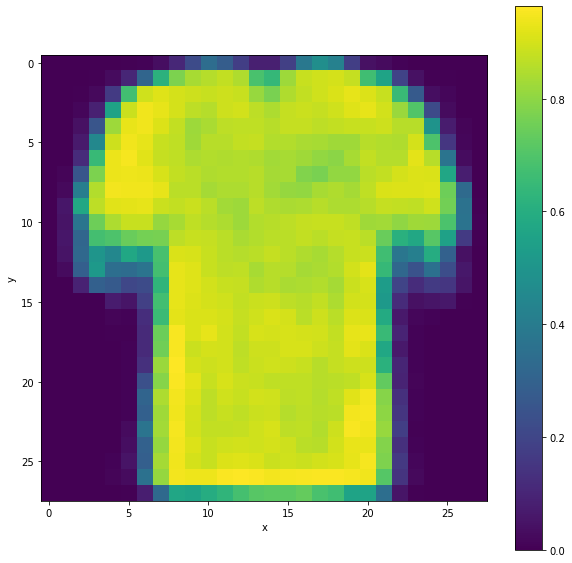

In [ ]:
def plot_unit_from_decoder(decoder, z, unit_size):
    # display a 2D plot of the unit classes in the latent space
    
    data = np.array([[z[0], z[1]]])
    unit = decoder.predict(data)
    unit = unit.reshape(unit_size, unit_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(unit)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()


plot_unit_from_decoder(decoder, [1.4,-1.3], 28)

# Увеличим размер скрытого пространства

In [ ]:
latent_dim = 4

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 14, 14, 64)   640         ['input_9[0][0]']                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 7, 7, 128)    73856       ['conv2d_8[0][0]']               
                                                                                                  
 flatten_4 (Flatten)            (None, 6272)         0           ['conv2d_9[0][0]']               
                                                                                            

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 4)]               0         
                                                                 
 dense_9 (Dense)             (None, 6272)              31360     
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 14, 14, 128)      147584    
 Transpose)                                                      
                                                                 
 conv2d_transpose_13 (Conv2D  (None, 28, 28, 64)       73792     
 Transpose)                                                      
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 28, 28, 1)        577 

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam()) # задаем оптимайзер
vae.fit(mnist_units, epochs=30, batch_size=128) # проводим обучение

Epoch 1/30
547/547 [==============================] - 11s 18ms/step - loss: 286.9773 - reconstruction_loss: 281.5964 - kl_loss: 5.3809
Epoch 2/30
547/547 [==============================] - 9s 17ms/step - loss: 247.9518 - reconstruction_loss: 243.5468 - kl_loss: 4.4050
Epoch 3/30
547/547 [==============================] - 8s 15ms/step - loss: 243.9653 - reconstruction_loss: 240.0270 - kl_loss: 3.9383
Epoch 4/30
547/547 [==============================] - 8s 15ms/step - loss: 241.9177 - reconstruction_loss: 238.1740 - kl_loss: 3.7437
Epoch 5/30
547/547 [==============================] - 8s 15ms/step - loss: 240.5829 - reconstruction_loss: 236.9317 - kl_loss: 3.6512
Epoch 6/30
547/547 [==============================] - 8s 16ms/step - loss: 239.5924 - reconstruction_loss: 235.9979 - kl_loss: 3.5945
Epoch 7/30
547/547 [==============================] - 9s 16ms/step - loss: 238.8747 - reconstruction_loss: 235.3175 - kl_loss: 3.5572
Epoch 8/30
547/547 [==============================] - 9s 16ms

По сравнению с сетью с 2 скрытыми слоями - сети с 6 скрытыми слоями удалось добиться уменьшения обеих составляющих ошибки. Лоссы стабилизировались.

## Визуализируем полученные результаты, зафиксировав несколько измерений.

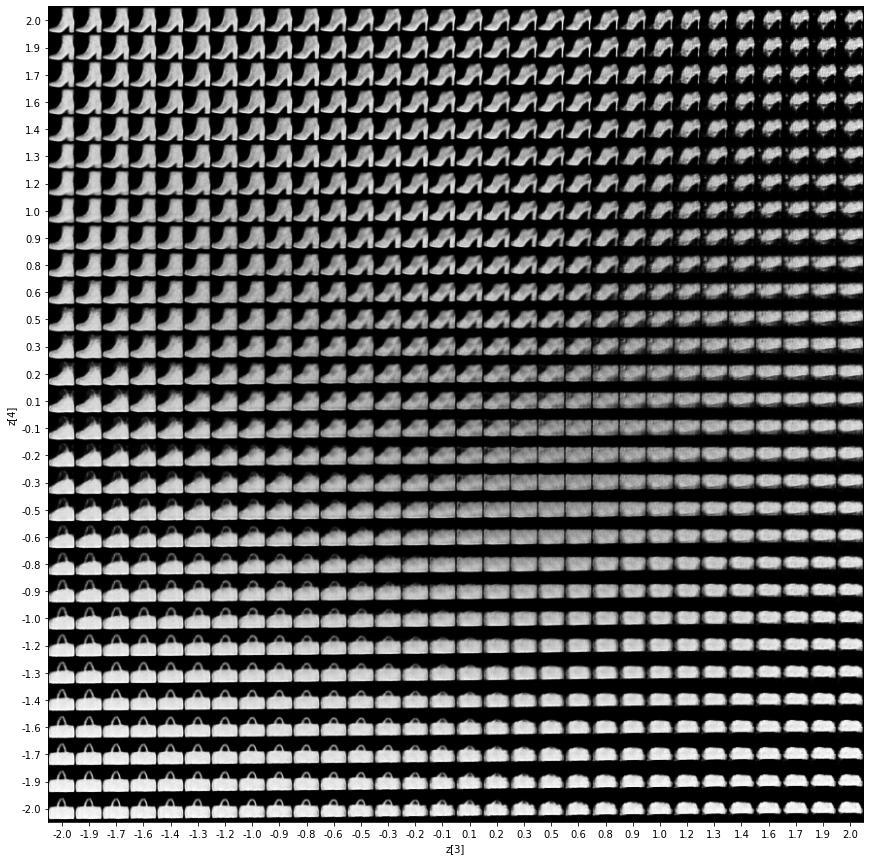

In [ ]:
def plot_latent_4(encoder, decoder):
    n = 30
    size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((size * n, size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[1, 0, xi, yi]])
            x_decoded = decoder.predict(z_sample)
            pic = x_decoded[0].reshape(size, size)
            figure[
                i * size : (i + 1) * size,
                j * size : (j + 1) * size,
            ] = pic

    plt.figure(figsize=(figsize, figsize))
    start_range = size // 2
    end_range = (n - 1) * size + start_range + 1
    pixel_range = np.arange(start_range, end_range, size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[3]")
    plt.ylabel("z[4]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_4(encoder, decoder)

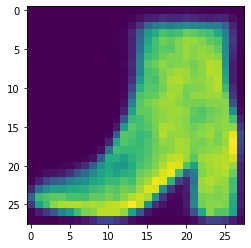

In [ ]:
x_decoded = decoder.predict([[1, 0, -1.7, 1.7]])
plt.imshow(x_decoded[0,:,:,0])
plt.show()

2. Сделайте краткий обзор какой-нибудь научной работы, посвященной тому или иному алгоритму
нейронных сетей, который не рассматривался на курсе. Проведите анализ: Чем отличается выбранная
вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной
архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

Статья - https://arxiv.org/pdf/1710.10196.pdf

Сеть ProgressiveGAN была представлена еще в 2018 году.

Главная проблема, которую она призвана решить, это генерация изображений в высоком разрешении. Авторы, работавшие на момент написания статьи в компании NVIDIA, отмечают, что GAN уже позволял на тот момент добиваться лучших результатов при генерации изображений, в сравнении с VAE и моделями авторегрессии типа PixelCNN. Слабым местом оставалось разрешение создаваемых картинок.

Поэтому они предложили подход, который подразумевает, что на начальных этапах генератор и дискриминатор работают с небольшим количеством слоев, фактически обрабатывая изображения очень маленького разрешения, концентрируюсь на высокоуровневых признаках. Затем количество и глубина слоев постепенно увеличиваются, что позволяет улавливать все более и более специфичные нюансы изображений. При этом все ранее добавленные слои остаются обучаемыми на протяжении всего процесса. В конечном итоге такая архитектура сети позволила авторам создать изображения с разрешением
x.

 Добавляемые слои вводятся в модель постепенно. На начальном этапе они трактуются в некоторой степени как блоки ResNet и участвуют в обучении с определенным весом.

Также говорится, что представленный подход также благоприятно сказывается на скорости обучения GANа.

В статье также рассматривается подход к динамической нормализации весов в генераторе и дискриминаторе, который призван устранить проблему нестабильности в процессе обучения, которая может возникать при сильной конкуренции генератора и дискриминатора.